##### Copyright 2020 The TensorFlow Hub Authors.


# Classify text to KSIC with BERT

- Load the KSIC dataset (json format)
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from official.nlp import optimization  # to create AdamW optimizer
import json
import pandas as pd
from tqdm.autonotebook import tqdm as notebook_tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
tf.__version__

'2.8.0'

### Read the KSIC dataset
* json format

In [2]:
# dataset_dir = os.path.join(os.getcwd(), 'patent')
# train_dir = os.path.join(dataset_dir, 'train')
f_list = ['ksic/ksic00.json', 'ksic/ksic01.json', 'ksic/ksic02.json']

* 일반적인 json 포맷과는 차이가 있고, 매 line마다 dict 형식의 데이터가 하나씩 있는 형태
* readline()으로 라인 단위로 읽어들인 후 json.loads(line)을 사용해 dict 형식으로 변환하여 dataframe에 추가

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 8
seed = 42

In [4]:
def read_colnames(fn):
    with open(fn, encoding='utf-8') as f:
        line = f.readline()
#     print(line)
    temp = json.loads(line)
#     print(temp.keys())
    return temp.keys()
# 첫줄을 읽고 컬럼 구성을 파악

In [5]:
col_name = read_colnames(f_list[0])

#### text 내의 \\\\" 문자열로 인해 json 파싱 오류가 발생
* escape 처리를 위해 replace 해 줌  :  line.replace('\\\\"', '\\"')

In [6]:
temp = []
error = []
for fname in f_list[1:]:
    with open(fname, encoding='utf-8') as f:
        for i, line in enumerate(f):
            try:
                temp.append(json.loads(line.replace('\\\\"', '\\"')))
            except Exception as e:
                error.append([e, line])
# print(temp)
raw_df = pd.DataFrame(data=temp, columns=col_name)

In [7]:
print(len(error), error[:2])

0 []


In [8]:
# raw_df.head(1)
print(len(raw_df))  # 1068453 확인 완료

1068453


### Making Label dictionary
* 전체 입력 데이터로부터 ksic의 중복 제거 리스트를 생성하고, index와 label간 변환을 위한 dict 객체 생성

In [9]:
ksic_label = raw_df['ksic'].unique()
ksic_index_dict = {i:label for i, label in enumerate(ksic_label)}
ksic_label_dict = {ksic_index_dict[key]:key for key in ksic_index_dict.keys()}

In [10]:
raw_df['ksic'].value_counts().to_csv('ksic/class_balance.csv')
class_cocunt = raw_df['ksic'].value_counts()
# 클래스 불균형이 존재하기 때문에 분류별 건수가 500건 이하인 경우는 제외하여 학습함
print(class_cocunt[:3])

28119    16022
26121    15241
27112    14819
Name: ksic, dtype: int64


### Class별 학습 데이터 수를 고려하여 500건 이상만 분류 예측
* 500건 이하가 수집된 KSIC 분류는 관련 특허가 거의 없는 기술 분야로써, 분류 예측 학습에서 제외
* 567개 KSIC 중 500건 미만인 KSIC는 제외하여 500개 label을 대상으로 학습 예정

In [11]:
class_cocunt2 = class_cocunt[class_cocunt>=500]
print(len(class_cocunt), '->', len(class_cocunt2))
# 567개 클래스 중 학습 데이터 건수가 500건 미만인 클래스는 학습에서 제외하여 500개 label을 대상으로 학습

567 -> 500


In [12]:
class_cocunt.head()

28119    16022
26121    15241
27112    14819
27199    14760
27192    12979
Name: ksic, dtype: int64

In [13]:
raw_df2 = raw_df.loc[raw_df['ksic'].isin(class_cocunt2.keys())].copy()
# A value is trying to be set on a copy of a slice from a DataFrame
# 위와 같이 raw_df2가 raw_df의 복제본인데, raw_df2에서 데이터를 편집하면 원본과 불일치가 발생하게 된다.
# 이 경우에는 .copy() 메서드를 사용하여 명시적으로 복사해서 사용하는게 좋다

In [14]:
print(len(raw_df), '->', len(raw_df2))  # 1,068,453 건 중 학습 데이터가 500건 미만인 클래스를 제외하여 1,055,662건 추출

1068453 -> 1055662


In [15]:
# KSIC 코드를 정수 레이블로 변환
raw_df2['label'] = raw_df2['ksic'].map(ksic_label_dict)
# raw_df.head()

In [16]:
raw_df2.head(1)

,ksic,an,ad,pn,pd,rn,rd,ipc,cpc,title,ab,cl,apg,invt,label
0,20411,1019570000830,19570723,1019580000974,19580228,100000313,19580702,C09D5/08,C09D5/084 | C09D193/00,방청 도료 제조법,국내에서 대량으로 구득할 수 있는 해조등으로 수입 품인 아마인유나 동유등을 절약할 ...,\n,김동규,김동규,0


### train set과 test set 분할
* 테스트셋의 비중은 20%, random_state=15, ksic를 기준으로 균등하게 20% 분할

In [17]:
train_input, test_input = train_test_split(raw_df2, random_state=15, test_size=0.2, stratify=raw_df2['ksic'], shuffle=True)
train_input, val_input = train_test_split(train_input, random_state=15, test_size=0.15, stratify=train_input['ksic'], shuffle=True)
# print(val_input.head(2))
# print(train_input['ksic'].value_counts())
# print(test_input['ksic'].value_counts())

In [157]:
print(train_input.shape, val_input.shape, test_input.shape)

(717849, 15) (126680, 15) (211133, 15)


In [131]:
# 파일 저장
train_input.to_csv('ksic/train_input.csv', encoding='utf-8', mode='w', index=False)
val_input.to_csv('ksic/val_input.csv', encoding='utf-8', mode='w', index=False)
test_input.to_csv('ksic/test_input.csv', encoding='utf-8', mode='w', index=False)

### 텍스트와 라벨쌍 추출
* Title, Astract, Claim으로부터 텍스트를 추출하고, 'label' 컬럼과 데이터 쌍 생성

In [18]:
def make_input_text(df):
    input_tl = df[['title', 'label']].copy()
    input_tl.rename(columns={'title':'text'}, inplace=True)
    input_ab = df[['ab', 'label']].copy()
    input_ab.rename(columns={'ab':'text'}, inplace=True)
    input_cl = df[['cl', 'label']].copy()
    input_cl.rename(columns={'cl':'text'}, inplace=True)
    input_text = pd.concat([input_tl, input_ab, input_cl]).copy()
    input_text['text_len'] = input_text['text'].str.len()
    input_text2 = input_text.loc[input_text['text_len'] > 3, ['text', 'label']].copy()  # 60813 rows × 3 columns 제거
    return input_text2

In [19]:
# # 텍스트 데이터 추출
# input_tl = raw_df[['title', 'label']]
# input_tl.rename(columns={'title':'text'}, inplace=True)
# input_ab = raw_df[['ab', 'label']]
# input_ab.rename(columns={'ab':'text'}, inplace=True)
# input_cl = raw_df[['cl', 'label']]
# input_cl.rename(columns={'cl':'text'}, inplace=True)
# # input_tl.head()
# print(len(input_tl), len(input_ab), len(input_cl))
# # 텍스트, 라벨쌍 합치기
# input_text = pd.concat([input_tl, input_ab, input_cl])
# input_text.head()
# # 텍스트가 없거나 너무 짧은 데이터 제거
# input_text['text_len'] = input_text['text'].str.len()
# input_text = input_text.loc[input_text['text_len'] > 3, ['text', 'label']]  # 60813 rows × 3 columns 제거
# print(len(input_text))  # 2979654 -> 2918120

In [20]:
# text와 label쌍으로 이루어진 데이터 생성
train_ds = make_input_text(train_input)
val_ds = make_input_text(val_input)
test_ds = make_input_text(test_input)

### 학습 데이터와 테스트 데이터를 임시 저장

In [21]:
# 파일 저장
train_ds.to_csv('ksic/train_ds.csv', encoding='utf-8', mode='w', index=False)
val_ds.to_csv('ksic/val_ds.csv', encoding='utf-8', mode='w', index=False)
test_ds.to_csv('ksic/test_ds.csv', encoding='utf-8', mode='w', index=False)

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [22]:
#@title Choose a BERT model to fine-tune

# bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


### 모델 입력

In [23]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(len(ksic_label), activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_ds['text'], train_ds['label'])).shuffle(train_ds['text'].shape[0]).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_ds['text'], val_ds['label'])).shuffle(val_ds['text'].shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_ds['text'], test_ds['label'])).shuffle(test_ds['text'].shape[0]).batch(batch_size)

# tutorial의 dataset은 tf.keras.utils.text_dataset_from_directory를 사용하나,
# 본 프로젝트에서는 paandas dataframe을 입력으로 하기 때문에 tf.data.Dataset.from_tensor_slices를 사용함
# 아래 사이트를 참고하여 dataset의 형태를 맞춰줌, 다만 텍스트가 유니코드로 보여지는 문제가 존재함.
# 학습에 문제가 없을지 점검 필요
# https://stackoverflow.com/questions/69660201/inputting-some-data-for-bert-model-using-tf-data-dataset-from-tensor-slices

2022-06-08 16:34:25.145279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 16:34:25.194037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 16:34:25.194176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 16:34:25.195030: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [25]:
train_dataset.take(1)
# <TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


# tf.constant(train_dataset.take(1))
# ValueError: Attempt to convert a value 
# (<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)
# with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>) to a Tensor.

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({ksic_index_dict[label]})')

Review: b'\xec\xb2\xa0\xea\xb0\x95\xec\x9b\x90\xeb\xa3\x8c \xeb\xb0\xb0\xed\x95\xa9\xeb\xb0\xa9\xeb\xb2\x95\xec\x97\x90 \xec\x9e\x88\xec\x96\xb4\xec\x84\x9c, \xeb\xb3\x80\xec\x88\x98\xec\x84\xa0\xec\x96\xb8 \xeb\xb0\x8f \xec\xb4\x88\xea\xb8\xb0\xec\xb9\x98 \xec\x84\xa4\xec\xa0\x95\xeb\x8b\xa8\xea\xb3\x84\xec\x99\x80, \xed\x94\x84\xeb\xa1\x9c\xec\x84\xb8\xec\x8a\xa4 \xec\xbb\xb4\xed\x93\xa8\xed\x84\xb0\xeb\xa1\x9c\xeb\xb6\x80\xed\x84\xb0 \xec\xb6\x94\xeb\xa1\xa0\xec\x9d\x98\xeb\xa2\xb0 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0\xeb\xa5\xbc \xeb\x84\xa4\xed\x8a\xb8\xec\x9b\x8d \xec\xa0\x84\xec\x86\xa1\xec\x9c\xbc\xeb\xa1\x9c \xec\x88\x98\xec\x8b\xa0\xeb\xb0\x9b\xec\x95\x84\xec\x84\x9c \xec\xb6\x94\xeb\xa1\xa0\xea\xb0\x80\xeb\x8a\xa5\xed\x95\x9c \xec\x96\xb8\xec\x96\xb4\xec\x9d\xb8 \xec\x98\xa4\xeb\xb8\x8c\xec\xa0\x9d\xed\x8a\xb8\xed\x98\x95 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0\xeb\xa1\x9c \xeb\x8b\xa4\xec\x9d\x8c\xea\xb3\xbc \xea\xb0\x99\xec\x9d\xb4 \xeb\xb3\x80\xed\x99\x98\xed\x95\x98\xeb\x8a

In [31]:
classifier_model = build_classifier_model()

In [32]:
# bert_raw_result = classifier_model(tf.constant(train_dataset.take(1)))
# print(tf.sigmoid(bert_raw_result))

In [33]:
# help(tf.data.Dataset.from_tensor_slices)

In [34]:
# help(tf.keras.utils.text_dataset_from_directory)

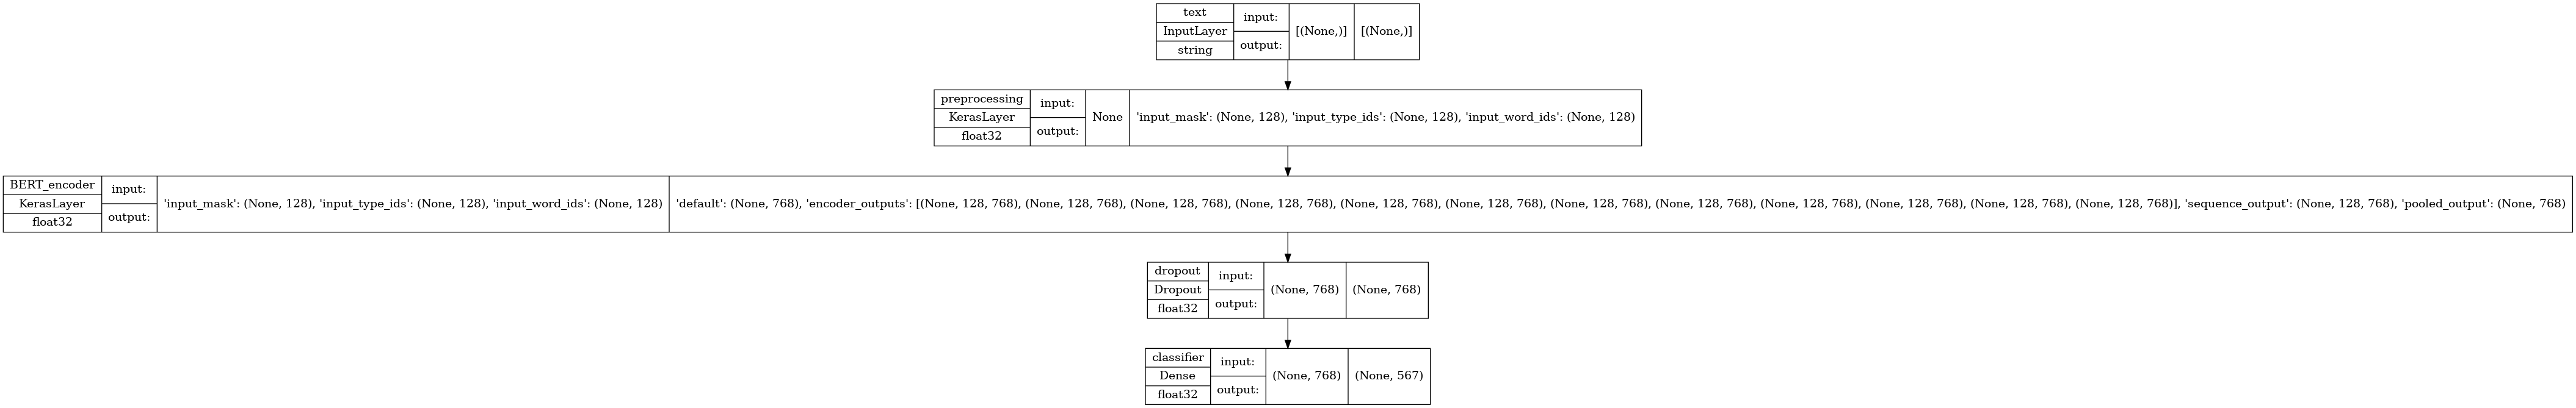

In [196]:
tf.keras.utils.plot_model(classifier_model, show_dtype=True, show_shapes=True, to_file='model.png')

In [36]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalCrossentropy()

In [191]:
# help(tf.keras.losses.SparseCategoricalCrossentropy)
help(tf.keras.metrics.SparseCategoricalCrossentropy)

Help on class SparseCategoricalCrossentropy in module keras.metrics:

class SparseCategoricalCrossentropy(MeanMetricWrapper)
 |  SparseCategoricalCrossentropy(*args, **kwargs)
 |  
 |  Computes the crossentropy metric between the labels and predictions.
 |  
 |  Use this crossentropy metric when there are two or more label classes.
 |  We expect labels to be provided as integers. If you want to provide labels
 |  using `one-hot` representation, please use `CategoricalCrossentropy` metric.
 |  There should be `# classes` floating point values per feature for `y_pred`
 |  and a single floating point value per feature for `y_true`.
 |  
 |  In the snippet below, there is a single floating point value per example for
 |  `y_true` and `# classes` floating pointing values per example for `y_pred`.
 |  The shape of `y_true` is `[batch_size]` and the shape of `y_pred` is
 |  `[batch_size, num_classes]`.
 |  
 |  Args:
 |    name: (Optional) string name of the metric instance.
 |    dtype: (Opt

In [37]:
# # tfds.load(np.array(input_text))
# train_dataset = tf.data.Dataset.from_tensor_slices((train_ds['text'], train_ds['label']))
# val_dataset = tf.data.Dataset.from_tensor_slices((val_ds['text'], val_ds['label']))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_ds['text'], test_ds['label']))

In [39]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

In [40]:
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [41]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_dataset, validation_data=val_dataset, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/3
     4/263508 [..............................] - ETA: 3:37:56 - loss: 6.2632 - sparse_categorical_crossentropy: 12.2350 

2022-06-08 16:35:50.545744: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


263508/263508 [==============================] - 15111s 57ms/step - loss: 5.5095 - sparse_categorical_crossentropy: 10.2013 - val_loss: 5.2838 - val_sparse_categorical_crossentropy: 8.9203
Epoch 2/3
133009/263508 [==============>...............] - ETA: 1:47:06 - loss: 5.2429 - sparse_categorical_crossentropy: 8.4173

In [160]:
# help(classifier_model.compute_metrics)
help(classifier_model.call)

Help on method call in module keras.engine.functional:

call(inputs, training=None, mask=None) method of keras.engine.functional.Functional instance
    Calls the model on new inputs.
    
    In this case `call` just reapplies
    all ops in the graph to the new inputs
    (e.g. build a new computational graph from the provided inputs).
    
    Args:
        inputs: A tensor or list of tensors.
        training: Boolean or boolean scalar tensor, indicating whether to run
          the `Network` in training mode or inference mode.
        mask: A mask or list of masks. A mask can be
            either a tensor or None (no mask).
    
    Returns:
        A tensor if there is a single output, or
        a list of tensors if there are more than one outputs.



In [44]:
loss, accuracy = classifier_model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

dataset_name = 'patent'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

reloaded_model = tf.saved_model.load(saved_model_path)

77511/77511 [==============================] - 3840s 50ms/step - loss: 5.1026 - sparse_categorical_crossentropy: 7.4670
Loss: 5.10257625579834
Accuracy: 7.466965675354004


2022-06-09 10:33:20.131510: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Export for inference

Now you just save your fine-tuned model for later use.

In [45]:
dataset_name = 'patent'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [46]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [47]:
def print_my_examples(inputs, results):
    result_for_printing = \
        [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                                                 for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

In [48]:
examples = [
    '본 발명은 OMA BCAST 서비스에서, 다양한 포맷으로 제작된 콘테츠들에 대해 각 가입자 단말기에서 별도의 변환 프로세싱 없이 콘텐츠를 재생할 수 있도록 서비스 제공자 측에서 각 가입자의 단말기에 적합하게 트랜스코딩하여 전송하는 방법에 관한 것이다.',  # this is the same sentence tried earlier
    '마스터 패킷 제어기와 데이터 서비스 노드간의 Ｒ-Ｐ 연결실패시 브로드캐스트/멀티캐스트 서비스 제공 방법 및시스템',
    '모듈식 MBMS(MULTIMEDIA BROADCAST AND MULTICAST SERVICE) 전달을 위한 기술들',
    '통신 단말기를 이용한 방송관련 채팅 서비스 방법 및시스템',
    '상황 기반 비정상 모니터링을 위한 방법들 및 시스템들',
    '사용자의 프로파일 정보를 이용한 광고 시청을 통한 무료통화 서비스 제공 시스템 및 그 방법'
]

In [109]:
# help(np.random.randint)

In [110]:
sample_index = np.random.randint(len(test_input), size=10)
print(sample_index)

[118141 105327 204745 152614  30150 197861  15173 157631 103258 188773]


In [126]:
# samples = raw_df2[raw_df2.iloc[sample_index], ['ksic','title','ab','cl','label']]
samples = test_input.iloc[sample_index]

In [145]:
ksic_label = pd.read_csv('ksic/KSIC_567_label.csv', sep='\t')
ksic_label = ksic_label.set_index('코드')
print(ksic_label)

        연번                        항목명
코드                                   
01110    1           곡물 및 기타 식량작물 재배업
01121    2                   채소작물 재배업
01122    3                   화훼작물 재배업
01123    4                종자 및 묘목 생산업
01131    5                   과실작물 재배업
...    ...                        ...
62090  563  기타 정보 기술 및 컴퓨터 운영 관련 서비스업
ICT출판  564         디지털출판 콘텐츠 개발 및 제작업
ICT영상  565         디지털영상 콘텐츠 개발 및 제작업
ICT음악  566         디지털음악 콘텐츠 개발 및 제작업
ICT교육  567         디지털교육 콘텐츠 개발 및 제작업

[567 rows x 2 columns]


In [151]:
ksic_label.loc['01122']['항목명']

'화훼작물 재배업'

### 요약문을 사용한 예측

In [127]:
samples.head(1)
examples = samples['ab'].to_numpy()
examples_label = samples['ksic'].to_numpy()
print(examples_label, '\n', examples[:2])

['28122' '20202' '28202' '29272' '27112' '28410' '21230' '33992' '25922'
 '10797'] 
 ['본 고안은 가입자의 댁내에 설치되어 광 가입자 망을 구축 형성하고자 사용되고 있는 광 네트워크 단말장치에 관한 것이다. \\n 본 고안에 따른 광 네트워크 단말장치에 의하면, 외부로부터 연결되는 광 커넥터가 케이스의 내부에 전부 삽입되는 상태로 접속되도록 하여, 상기 광 커넥터가 케이스의 외부로 노출되지 않는 구조이므로, 사용자의 실수 혹은 호기심에 따른 광 커넥터의 파손을 방지하고, 특히 어린이가 호기심에 의해 광 커넥터를 분리하여 광원(레이저 빛)을 눈에 비출 경우, 시력이 손상되거나 혹은 상실되는 것을 방지할 수 있도록 한 것이다.\\n 나아가, 본 고안에서는 외부로부터 연결되는 광 커넥터를 접속 및 분리할 경우, 특수 제작된 별도의 집게를 사용하도록 하여, 임의적인 분리로 인한 광 커넥터의 손상시, 가입자와 설치업체간에 책임소지를 투명하게 함으로써, 합리적인 관리가 이루어질 수 있도록 한 것이다.\\n 본 고안은, 광 송수신기로부터 인출된 광 커넥터와 접속하게 되는 광 아답터가 접속공과 일치하는 상태로 수평 배치되면서 접속공을 형성한 케이스의 내측면으로부터 거리를 두고 설치되어, 외부로부터 접속공을 통해 광 아답터와 접속시, 광 커넥터가 외부로 노출되지 않도록 케이스 내부로 전부 수용됨으로써, 광 커넥터의 노출에 따른 파손과 손상이 방지되도록 하는 광 네트워크 단말장치가 제공된다.  \\n 또한, 본 고안은, 외부로부터 연결되는 광 커넥터가 케이스 내부로 전부 수용되는 상태로 광 송수신기에 접속될 수 있도록 하기 위하여, 상기 광 송수신기가 접속공을 형성한 케이스의 내측면으로부터 거리를 두고 설치됨으로써, 상기 케이스 외부로 광 커넥터의 노출에 따른 파손과 손상이 방지되도록 하는 광 네트워크 단말장치가 제공된다.  \\n'
 '본 발명은 반도체소자 밀봉용 고기능 에폭시수지의 제조방법에 관한 것으로서,

In [153]:
result = classifier_model.predict(tf.constant(examples))
result_predicted = np.argmax(result, axis = 1)
print(result_predicted)
for i, pred in enumerate(result_predicted):
    print('KSIC: %s(%s)\n예측: %s(%s)\nAbst: %s\n'%(examples_label[i], ksic_label.loc[examples_label[i]]['항목명'], ksic_index_dict[pred], ksic_label.loc[ksic_index_dict[pred]]['항목명'], examples[i][:50]))
#     print('KSIC: %s, predict: %s, Abst: %s\n'%(examples_label[i], ksic_index_dict[pred], examples[i][:50]))    

[ 79  89 547  49 561 547   6 561  49  18]
KSIC: 28122(전기회로 접속장치 제조업)
예측: 28119(기타 전기 변환장치 제조업)
Abst: 본 고안은 가입자의 댁내에 설치되어 광 가입자 망을 구축 형성하고자 사용되고 있는 광 네트

KSIC: 20202(합성수지 및 기타 플라스틱 물질 제조업)
예측: 20202(합성수지 및 기타 플라스틱 물질 제조업)
Abst: 본 발명은 반도체소자 밀봉용 고기능 에폭시수지의 제조방법에 관한 것으로서, 하기 구조식(Ⅱ

KSIC: 28202(축전지 제조업)
예측: 26121(발광 다이오드 제조업)
Abst: \n\t\t본 발명은 이차 전지 전극용 바인더 조성물 및 이를 포함하는 전극 합제에 관한 

KSIC: 29272(디스플레이 제조용 기계 제조업)
예측: 26521(라디오, 녹음 및 재생 기기 제조업)
Abst: 내용 없음.\n

KSIC: 27112(전기식 진단 및 요법 기기 제조업)
예측: 27112(전기식 진단 및 요법 기기 제조업)
Abst: 더모코스메틱, 의료 또는 심미적 치료들을 위한 레이저 디바이스는,\nA) 램프-펌프 소스를

KSIC: 28410(전구 및 램프 제조업)
예측: 26121(발광 다이오드 제조업)
Abst: 본 발명의 LED모듈을 이용한 조립식 등기구에 관한 것으로, 부채꼴의 원호상으로 다수 형성

KSIC: 21230(동물용 의약품 제조업)
예측: 21210(완제 의약품 제조업)
Abst: 본 발명은 글루탐산염 이상을 치료하기 위한 방법 및 NAALADase 저해제를 사용하여 동

KSIC: 33992(라이터, 연소물 및 흡연용품 제조업)
예측: 27112(전기식 진단 및 요법 기기 제조업)
Abst: 액체 기화 흡입 장치가 개시된다.\n 개시되는 액체 기화 흡입 장치는 사용자가 흡입할 수 

KSIC: 25922(도금업)
예측: 26521(라디오, 녹음 및 재생 기기 제조업)
Abst: 내용 없음.\n

KSIC: 10797(건강 기능식품 제조업)
예

### 발명의 명칭을 사용한 예측

In [154]:
samples.head(1)
examples = samples['title'].to_numpy()
examples_label = samples['ksic'].to_numpy()
# print(examples_label, '\n', examples[:2])
result = classifier_model.predict(tf.constant(examples))
result_predicted = np.argmax(result, axis = 1)
# print(result_predicted)
for i, pred in enumerate(result_predicted):
    print('KSIC: %s(%s)\n예측: %s(%s)\nAbst: %s\n'%(examples_label[i], ksic_label.loc[examples_label[i]]['항목명'], ksic_index_dict[pred], ksic_label.loc[ksic_index_dict[pred]]['항목명'], examples[i][:50]))
#     print('KSIC: %s, predict: %s, Abst: %s\n'%(examples_label[i], ksic_index_dict[pred], examples[i][:50]))    

KSIC: 28122(전기회로 접속장치 제조업)
예측: 26521(라디오, 녹음 및 재생 기기 제조업)
Abst: 광 네트워크 단말장치

KSIC: 20202(합성수지 및 기타 플라스틱 물질 제조업)
예측: 20202(합성수지 및 기타 플라스틱 물질 제조업)
Abst: 반도체소자 밀봉용 고기능 에폭시수지의 제조방법

KSIC: 28202(축전지 제조업)
예측: 28202(축전지 제조업)
Abst: 이차 전지 전극용 바인더 조성물 및 전극 합제

KSIC: 29272(디스플레이 제조용 기계 제조업)
예측: 29132(기체 펌프 및 압축기 제조업)
Abst: 액정표시소자 제조용 롤코팅기

KSIC: 27112(전기식 진단 및 요법 기기 제조업)
예측: 27112(전기식 진단 및 요법 기기 제조업)
Abst: 더모코스메틱 치료들을 위한 레이저 디바이스 및 추적 키트

KSIC: 28410(전구 및 램프 제조업)
예측: 29132(기체 펌프 및 압축기 제조업)
Abst: ＬＥＤ모듈을 이용한 조립식 등기구

KSIC: 21230(동물용 의약품 제조업)
예측: 21210(완제 의약품 제조업)
Abst: 날라다아제조성물, 글루탐산염 이상 치료법 및 동물내의 뉴우런활성법

KSIC: 33992(라이터, 연소물 및 흡연용품 제조업)
예측: 29132(기체 펌프 및 압축기 제조업)
Abst: 액체 기화 흡입 장치

KSIC: 25922(도금업)
예측: 26291(전자 축전기 제조업)
Abst: 도금(鍍金) 처리용 바렐

KSIC: 10797(건강 기능식품 제조업)
예측: 20423(화장품 제조업)
Abst: 홍삼추출물 및 인삼 열매 추출물을 포함하는 조성물



### test set을 사용한 예측
* 발명의 명칭, 요약, 청구항

In [161]:
examples = test_input['title'].to_numpy()
examples_label = test_input['ksic'].to_numpy()
result = classifier_model.predict(tf.constant(examples))
result_predicted = np.argmax(result, axis = 1)
for i, pred in enumerate(result_predicted[:10]):
    print('KSIC: %s(%s)\n예측: %s(%s)\nAbst: %s\n'%(examples_label[i], ksic_label.loc[examples_label[i]]['항목명'], ksic_index_dict[pred], ksic_label.loc[ksic_index_dict[pred]]['항목명'], examples[i][:50]))
#     print('KSIC: %s, predict: %s, Abst: %s\n'%(examples_label[i], ksic_index_dict[pred], examples[i][:50]))    

KSIC: 38230(건설 폐기물 처리업)
예측: 28903(교통 신호장치 제조업)
Abst: 건설폐기물로부터 시멘트 페이스트 및 모르타르가 제거된재생골재 및 모래를 생산하는 방법 및 

KSIC: 25942(그 외 금속 파스너 및 나사제품 제조업)
예측: 28519(기타 가정용 전기 기기 제조업)
Abst: 이탈 방지 장치를 갖는 나사

KSIC: 29271(반도체 제조용 기계 제조업)
예측: 27192(정형 외과용 및 신체 보정용 기기 제조업)
Abst: 반도체 제조용 열교환기 누수 보수보강방법

KSIC: 27302(사진기, 영사기 및 관련 장비 제조업)
예측: 27302(사진기, 영사기 및 관련 장비 제조업)
Abst: 카메라용 손떨림 보정장치

KSIC: 27302(사진기, 영사기 및 관련 장비 제조업)
예측: 27302(사진기, 영사기 및 관련 장비 제조업)
Abst: 카메라의 파인더 렌즈 배율 가변 시스템

KSIC: 19101(코크스 및 관련제품 제조업)
예측: 27112(전기식 진단 및 요법 기기 제조업)
Abst: 원료 처리 장치 및 그 처리 방법

KSIC: 62021(컴퓨터 시스템 통합 자문 및 구축 서비스업)
예측: 27112(전기식 진단 및 요법 기기 제조업)
Abst: 주문형 맞춤 설계를 위한 데이터베이스 공유형 제품 설계시스템 및 그 방법

KSIC: 29163(컨베이어 장치 제조업)
예측: 29172(공기 조화장치 제조업)
Abst: 수평 이송 장치

KSIC: 26529(기타 음향기기 제조업)
예측: 26129(기타 반도체 소자 제조업)
Abst: 전자 장치 및 전자 장치의 오디오 처리 방법

KSIC: 24290(기타 1차 비철금속 제조업)
예측: 28119(기타 전기 변환장치 제조업)
Abst: 연주설비의 디버러 제어 방법



In [164]:
test_result = test_input.copy()
test_result.shape  # (211133, 15)
result_predicted.shape  # (211133,)

(211133,)

In [173]:
test_result['pred_tl'] = result_predicted
test_result['pred_tl_ksic'] = test_result['pred'].map(ksic_index_dict)
# test_result.to_csv('ksic/test_result.csv')
# ksic	an	ad	pn	pd	rn	rd	ipc	cpc	title	ab	cl	apg	invt	label

In [185]:
test_input[test_input['ab'].isna()==True]
test_input['ab2'] = test_input['ab'].fillna(test_input['title'])
test_input[test_input['ab2'].isna()==True]

test_input[test_input['ab'].isna()==True]
test_input['cl2'] = test_input['cl'].fillna(test_input['ab2'])
test_input[test_input['cl2'].isna()==True]

,ksic,an,ad,pn,pd,rn,rd,ipc,cpc,title,ab,cl,apg,invt,label,ab2,cl2


In [186]:
examples = test_input['ab2'].to_numpy()
ab_result = classifier_model.predict(tf.constant(examples))
ab_predicted = np.argmax(ab_result, axis = 1)
test_result['pred_ab'] = ab_predicted
test_result['pred_ab_ksic'] = test_result['pred_ab'].map(ksic_index_dict)

In [187]:
examples = test_input['cl2'].to_numpy()
cl_result = classifier_model.predict(tf.constant(examples))
cl_predicted = np.argmax(cl_result, axis = 1)
test_result['pred_cl'] = cl_predicted
test_result['pred_cl_ksic'] = test_result['pred_cl'].map(ksic_index_dict)

In [188]:
test_result.to_csv('ksic/test_result.csv')

### Visualization

In [189]:
tf.keras.utils.plot_model(classifier_model)
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'sparse_categorical_crossentropy', 'val_loss', 'val_sparse_categorical_crossentropy'])


In [197]:
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']
sparse_categorical_crossentropy = history_dict['sparse_categorical_crossentropy']
val_sparse_categorical_crossentropy = history_dict['val_sparse_categorical_crossentropy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [199]:
epochs = range(1, len(sparse_categorical_crossentropy) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

<Figure size 720x432 with 0 Axes>

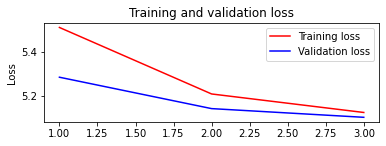

In [200]:
plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

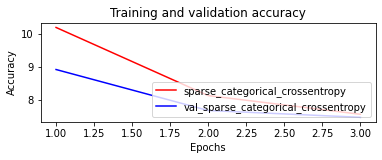

In [202]:
plt.subplot(2, 1, 2)
plt.plot(epochs, sparse_categorical_crossentropy, 'r', label='sparse_categorical_crossentropy')
plt.plot(epochs, val_sparse_categorical_crossentropy, 'b', label='val_sparse_categorical_crossentropy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [137]:
ksic_label_dict

{'20411': 0,
 '25121': 1,
 '20491': 2,
 '30110': 3,
 '11111': 4,
 '23231': 5,
 '21210': 6,
 '29210': 7,
 '19102': 8,
 '14192': 9,
 '29193': 10,
 '24111': 11,
 '20132': 12,
 '20493': 13,
 '15211': 14,
 '29180': 15,
 '20311': 16,
 '27216': 17,
 '27192': 18,
 '38312': 19,
 '13401': 20,
 '27199': 21,
 '42491': 22,
 '10401': 23,
 '24211': 24,
 '17110': 25,
 '33920': 26,
 '10220': 27,
 '20321': 28,
 '10802': 29,
 '10794': 30,
 '20111': 31,
 '22199': 32,
 '29242': 33,
 '23232': 34,
 '28111': 35,
 '13101': 36,
 '29150': 37,
 '29194': 38,
 '23311': 39,
 '18121': 40,
 '10742': 41,
 '24113': 42,
 '12000': 43,
 '10713': 44,
 '19221': 45,
 '13211': 46,
 '24131': 47,
 '33992': 48,
 '26521': 49,
 '20499': 50,
 '29191': 51,
 '27302': 52,
 '19229': 53,
 '15219': 54,
 '24219': 55,
 '25119': 56,
 '16102': 57,
 '10792': 58,
 '24213': 59,
 '10743': 60,
 '27219': 61,
 '35200': 62,
 '20494': 63,
 '10403': 64,
 '29175': 65,
 '20121': 66,
 '28121': 67,
 '10799': 68,
 '28902': 69,
 '23119': 70,
 '29291': 71,
 '

In [136]:
ksic_index_dict

{0: '20411',
 1: '25121',
 2: '20491',
 3: '30110',
 4: '11111',
 5: '23231',
 6: '21210',
 7: '29210',
 8: '19102',
 9: '14192',
 10: '29193',
 11: '24111',
 12: '20132',
 13: '20493',
 14: '15211',
 15: '29180',
 16: '20311',
 17: '27216',
 18: '27192',
 19: '38312',
 20: '13401',
 21: '27199',
 22: '42491',
 23: '10401',
 24: '24211',
 25: '17110',
 26: '33920',
 27: '10220',
 28: '20321',
 29: '10802',
 30: '10794',
 31: '20111',
 32: '22199',
 33: '29242',
 34: '23232',
 35: '28111',
 36: '13101',
 37: '29150',
 38: '29194',
 39: '23311',
 40: '18121',
 41: '10742',
 42: '24113',
 43: '12000',
 44: '10713',
 45: '19221',
 46: '13211',
 47: '24131',
 48: '33992',
 49: '26521',
 50: '20499',
 51: '29191',
 52: '27302',
 53: '19229',
 54: '15219',
 55: '24219',
 56: '25119',
 57: '16102',
 58: '10792',
 59: '24213',
 60: '10743',
 61: '27219',
 62: '35200',
 63: '20494',
 64: '10403',
 65: '29175',
 66: '20121',
 67: '28121',
 68: '10799',
 69: '28902',
 70: '23119',
 71: '29291',
 7

In [77]:
# reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
# original_results = tf.sigmoid(classifier_model(tf.constant(examples)))
reloaded_results = reloaded_model(tf.constant(examples))
result = classifier_model.predict(tf.constant(examples))
result_predicted = np.argmax(result, axis = 1)

In [84]:
for i in result_predicted:
    print(i, ksic_index_dict[i])

565 26329
565 26329
565 26329
181 28903
563 26129
561 27112


In [76]:
# help(tf.nn.softmax)

In [64]:
print(reloaded_results.shape)
print(tf.nn.softmax(reloaded_results))

(6, 567)
tf.Tensor(
[[1.9431334e-03 4.0589331e-04 1.2175862e-03 ... 1.4876358e-03
  2.8474210e-02 5.4941761e-08]
 [2.0188200e-03 3.3095386e-04 1.7554187e-03 ... 2.4041440e-03
  4.7869626e-02 6.2883949e-08]
 [1.3102700e-03 2.7627705e-04 1.5226485e-03 ... 3.7246358e-03
  6.5068580e-02 7.0045452e-08]
 [4.6185846e-03 3.1183194e-04 1.9605451e-03 ... 4.0138406e-03
  9.9091623e-03 7.6360955e-08]
 [2.3445520e-03 1.8015013e-04 2.6380799e-03 ... 7.0497897e-03
  5.1095746e-02 8.5871271e-08]
 [3.2486115e-03 3.5447354e-04 1.8490922e-03 ... 3.0158395e-03
  2.7696563e-02 6.5916439e-08]], shape=(6, 567), dtype=float32)


In [54]:
# print('Results from the saved model:')
# print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
# print_my_examples(examples, original_results)
print_my_examples(examples, reloaded_results)

Results from the model in memory:


TypeError: print_my_examples() missing 1 required positional argument: 'results'

If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [51]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: 본 발명은 OMA BCAST 서비스에서, 다양한 포맷으로 제작된 콘테츠들에 대해 각 가입자 단말기에서 별도의 변환 프로세싱 없이 콘텐츠를 재생할 수 있도록 서비스 제공자 측에서 각 가입자의 단말기에 적합하게 트랜스코딩하여 전송하는 방법에 관한 것이다. : score: 0.001466
input: 마스터 패킷 제어기와 데이터 서비스 노드간의 Ｒ-Ｐ 연결실패시 브로드캐스트/멀티캐스트 서비스 제공 방법 및시스템 : score: 0.000067
input: 모듈식 MBMS(MULTIMEDIA BROADCAST AND MULTICAST SERVICE) 전달을 위한 기술들 : score: 0.000046
input: 통신 단말기를 이용한 방송관련 채팅 서비스 방법 및시스템 : score: 0.000090
input: 상황 기반 비정상 모니터링을 위한 방법들 및 시스템들  : score: 0.000012
input: 사용자의 프로파일 정보를 이용한 광고 시청을 통한 무료통화 서비스 제공 시스템 및 그 방법 : score: 0.000153



### 토크나이징

In [ ]:
def build_preprocess_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    return encoder_inputs

In [ ]:
preprocessed_text = []
preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
# 1줄 단위 토크나이징
for text in train_ds['text'][:2]:
    print([text])
    bert_raw_result = preprocess_model([text])
    preprocessed_text.append(bert_raw_result)
# print(tf.sigmoid(bert_raw_result))
print(preprocessed_text)

In [ ]:
# 배치 단위 토크나이징
text_preprocessed = preprocess_model(train_ds['text'][:10])
print(text_preprocessed)
# print(text_preprocessed['input_word_ids'])
# input_word_ids, input_type_ids, input_mask
# for i, item in enumerate(text_preprocessed['input_word_ids']):
#     print(i, item[:10])
# for i, item in enumerate(text_preprocessed['input_type_ids']):
#     print(i, item[:10])
for i, item in enumerate(text_preprocessed['input_mask']):
    print(i, item[:10])

In [ ]:
# 배치 단위 토크나이징
train_preprocessed_text = preprocess_model(train_ds['text'][:10])
print(train_preprocessed_text)
# print(text_preprocessed['input_word_ids'])
# input_word_ids, input_type_ids, input_mask
# for i, item in enumerate(text_preprocessed['input_word_ids']):
#     print(i, item[:10])
# for i, item in enumerate(text_preprocessed['input_type_ids']):
#     print(i, item[:10])
for i, item in enumerate(train_preprocessed_text['input_mask']):
    print(i, item[:10])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_preprocessed_text, train_ds['label']))

In [ ]:
# preprocessed_text = preprocessed_model()
for text in train_ds['text'][:10]:
    print(text)
    bert_raw_result = preprocess_model(text)
# print(tf.sigmoid(bert_raw_result))


# text_test = train_input[40]
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

### 저장한 csv 파일로부터 tf.data 를 사용하여 데이터 입력 파이프라인 생성

In [ ]:
# # tf.data를 사용하여 dataset 객체 생성
# test_ds = tf.data.experimental.make_csv_dataset(['ksic/train_ds.csv'], batch_size=batch_size, label_name='label',
#                                                num_epochs=3)
# # train_ds = tf.data.TextLineDataset(['ksic/train_ds.csv'])
# # test_ds = tf.data.TextLineDataset(['ksic/test_ds.csv'])
# for batch, label in test_ds.take(1):
#     for key, value in batch.items():
#         print(key, value.numpy())

In [ ]:
# help(tf.data.experimental.CsvDataset)

### DataFrame 객체로부터 tf.data를 사용하여 데이터 입력 파이프라인 생성
* tf.data.Dataset를 사용하여 데이터 로드하기
* tf.data.Dataset.from_tensor_slices를 사용하여 pandas 데이터 프레임에서 값을 읽습니다.
* tf.data.Dataset를 사용할 때의 이점 중 하나는 간단하고 효율적인 데이터 파이프라인을 작성할 수 있다는 것입니다.
* 자세한 내용은 데이터 로드 가이드를 참조하세요.
    * https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
    * https://www.tensorflow.org/guide/data

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_ds['text'], test_ds['label']))
# test_ds = tf.data.Dataset.from_tensor_slices(dict(test_ds))

#### 텍스트가 unicode 문자열로 표현됨, 원인과 캐릭터셋 표현 방법 확인 필요
* https://www.tensorflow.org/text/guide/unicode

In [ ]:
next(iter(test_dataset))[0]

In [ ]:
for line in test_dataset.take(2):
#     print([item.numpy() for item in line])
#     print(line)
#     print(tf.strings.unicode_decode(line[0], input_encoding='UTF-8'))
    tf.strings.unicode_encode(tf.RaggedTensor.from_tensor(line[0]), output_encoding='UTF-8')  # 잘 안되네

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_ds['text'], train_ds['label']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_ds['text'], test_ds['label']))

In [ ]:
for item in train_dataset.take(1):
    print(item)

In [ ]:
# for element in input_text.as_numpy_iterator():
#     print(element)

# dataset shuffle
counter = tf.data.experimental.Counter()
train_dataset = tf.data.Dataset.zip((counter, train_dataset))
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset = train_dataset.batch(20)

# 데이터 확인
# n,line_batch = next(iter(dataset))
# print(n.numpy(), line_batch)
# for text, label in input_text.take(batch_size):
#     print(text.numpy(), label.numpy(), ksic_index_dict[label.numpy()])

In [ ]:
# print(train_ds.take(1).numpy())
for item in train_dataset.take(batch_size):
    print(item)
#     label = label_batch.numpy()
#     print(f'Label : {label} ({ksic_index_dict[label]})')

#### training
* 여러 가지 방법으로 tf.keras 모델에 데이터를 주입할 수 있습니다. 파이썬 제너레이터(generator)와 넘파이 배열을 입력으로 사용할 수 있습니다.
* tf.data 패키지를 사용하여 모델에 데이터를 주입하는 것이 권장되는 방법입니다. 이 패키지는 데이터 조작을 위한 고성능 클래스들을 포함하고 있습니다.
* tf.queue는 데이터 구조로만 지원되고 입력 파이프라인으로는 지원되지 않습니다.

#### 데이터셋 사용하기
* 텐서플로 데이터셋(Datasets) 패키지(tfds)는 tf.data.Dataset 객체로 정의된 데이터셋을 적재하기 위한 유틸리티가 포함되어 있습니다.
* 예를 들어 tfds를 사용하여 MNIST 데이터셋을 적재하는 코드는 다음과 같습니다:

In [ ]:
# tfds.load(np.array(input_text))
train_ds = tf.data.Dataset.from_tensor_slices((train_input['text'], train_input['label']))
test_ds = tf.data.Dataset.from_tensor_slices((test_input['text'], test_input['label']))

In [ ]:
 tf.cast(training_df[features].values, tf.float32),
        tf.cast(training_df['target'].values, tf.int32)
        
# datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)
# mnist_train, mnist_test = datasets['train'], datasets['test']

In [ ]:
# 오리지널 코드에서는 train과 test 데이터가 폴더를 사용하여 구분되어 있다. KSIC는 raw dataframe을 미리 잘라서 test를 생성해줘야 한다.
# raw_train_ds = tf.keras.utils.text_dataset_from_directory(
#     'patent/train',
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset='training',
#     seed=seed)

# class_names = raw_train_ds.class_names
# train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# val_ds = tf.keras.utils.text_dataset_from_directory(
#     'patent/train',
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset='validation',
#     seed=seed)

# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# test_ds = tf.keras.utils.text_dataset_from_directory(
#     'patent/test',
#     batch_size=batch_size)

# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
type(train_ds)

In [ ]:
print(train_ds.take(1))

Let's take a look at a few reviews.

In [ ]:
for text_batch, label_batch in train_ds.take(batch_size):
    print(text_batch.numpy())
    label = label_batch.numpy()
    print(f'Label : {label} ({ksic_index_dict[label]})')
#     for i in range(3):
#         print(f'test: {text_batch.numpy()[i][:100]}')
#         label = label_batch.numpy()[i]
#         print(f'Label : {label} ({class_names[label]})')


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = train_input[40]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(len(ksic_label), activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalCrossentropy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
help(tf.data.experimental.cardinality)

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
# Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
# Epoch 1/5
# 248/625 [==========>...................] - ETA: 8:30 - loss: 0.5818 - binary_accuracy: 0.6627
# 04.29, libcudnn 없음 오류 발생, GPU 미사용시에 16core를 모두 활용 중이며, 1 epoch마다 13분 가량 소요

# Next. multi_cased_L-12_H-768_A-12 사용
# Next. KPC 분류 결과 활용

# gpu 설정을 완료하니 1 epoch마다 1분으로 1/13 감소

In [ ]:
# https://developer.nvidia.com/rdp/cudnn-download

# Download cuDNN v8.4.0 (April 1st, 2022), for CUDA 11.x
#  - Local Installers for Windows and Linux, Ubuntu(x86_64, armsbsa)
#   - Local Installer for Ubuntu20.04 x86_64 (Deb)

# sudo dpkg -i libcudnn8-dev_8.1.1.33-1+cuda11.2_amd64.deb
# [출처] [NVIDIA] Could not load dynamic library 'libcudnn.so.8' 에러 해결|작성자 뚝이파파
# 의존성 에러 발생

# linux용 파일을 다운로드받아 설치 시도.
# 압축을 푼 후 필요한 파일들을 cuda toolkt 폴더로 복사.
# $ sudo cp cuda/include/cudnn.h /usr/local/cuda/include
# $ sudo cp cuda/lib64/libcudnn* /usr/local/cuda/lib64
# $ sudo chmod a+r /usr/local/cuda/include/cudnn.h /usr/local/cuda/lib64/libcudnn*
# [출처] [NVIDIA] Could not load dynamic library 'libcudnn.so.8' 에러 해결|작성자 뚝이파파

# sudo apt-get install libcupti-dev
# sudo apt --fix-broken install

# 이거 실행해보고 ubuntu에서 기록 남기자.

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [ ]:
# history_dict = history.history
# print(history_dict.keys())

# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)
# fig = plt.figure(figsize=(10, 6))
# fig.tight_layout()

# plt.subplot(2, 1, 1)
# # r is for "solid red line"
# plt.plot(epochs, loss, 'r', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# # plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.

In [ ]:
# 원시코드
# https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Setup

In [ ]:
# # A dependency of the preprocessing for BERT inputs
# !pip install -q -U "tensorflow-text==2.8.*"
# !pip install -q tf-models-official==2.7.0

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).